In [1]:
import torch
import gpytorch
import numpy as np
import optuna
import matplotlib.pyplot as plt
from src.plotting import plot_gp, plot_alpha_beta, plot_train_test_split

from src.data_loader import PVDataLoader
from src import data_loader as dl
from src.models import ExactGPModel, BetaGP
from src.beta_likelihood import BetaLikelihood_MeanParametrization
from optuna.visualization import plot_optimization_history, plot_param_importances

In [2]:
# set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 0
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 15
RADIUS = 0.35
COORDS = (55, -1.5)
IDX = 6

==> Loading data
==> Loaded data in: 0 m : 8 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



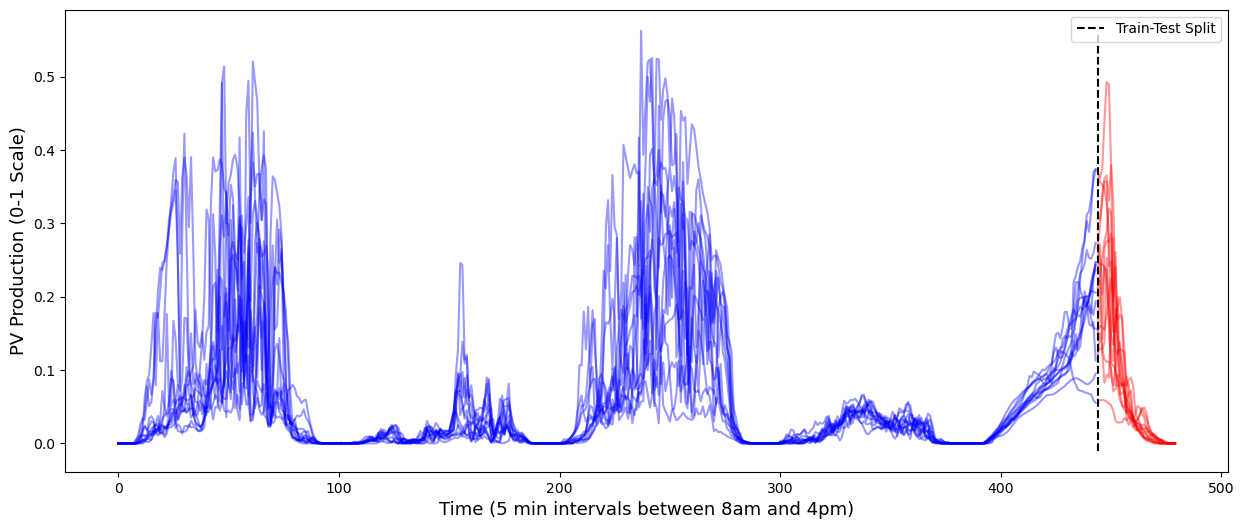

In [3]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

time, y = loader.get_time_series()
x_train, y_train, x_test, y_test = dl.train_test_split(time, y, n_hours=3)
plot_train_test_split(y_train, y_test)

In [4]:
# get individual time series
y_in = y

if y_in.max() > 1:
    y_in[y_in > 1] = 1
# get time related variables
periodic_time = dl.periodic_mapping(time, DAY_MIN, DAY_MAX, MINUTE_INTERVAL)
x = torch.stack([time, periodic_time], dim=1)

# standardize input
x = (x - x.mean(dim=0)) / x.std(dim=0)

# split into train and test
x_train, y_train, x_test, y_test = dl.train_test_split(x, y_in, n_hours=3)

# use all data as inducing points
x_inducing = x_train
y_inducing = y_train

# Stochastic Variational Inference for Gaussian Processes

Limitations:
- stochastic updates which can cause optimization problems and no guarantee of the global optimum is guaranteed, careful initialization and tuning of hyperparameters.
- not exact training data but inducing points (hyperparameter choice)
- not closed form solution for posterior s.t. solution is not exact


Strengths:
- non-gaussian likelihood for flexibility
- scalability
- uncertainty estimation
- approximate inference can capture important aspects of the underlying disitribtuions (giving fairly accurate predictions)

# Kernels

In [6]:
from gpytorch.kernels import MaternKernel, ScaleKernel, AdditiveKernel, ProductKernel, PeriodicKernel
from gpytorch.means import ConstantMean
# TODO add a prior to the period in periodic
matern = MaternKernel(nu=3/2, 
                      ard_num_dims=x.shape[1], 
                      lengthscale_prior=gpytorch.priors.GammaPrior(2, 8),
                      lengthscale_constraint=gpytorch.constraints.Positive()
                      )
periodic = PeriodicKernel(period_length_prior=gpytorch.priors.GammaPrior(3, 2),
                            period_length_constraint=gpytorch.constraints.Positive()
                        )
scaled_matern = ScaleKernel(matern, 
                            outputscale_prior=gpytorch.priors.GammaPrior(5, 2),
                            outputscale_constraint=gpytorch.constraints.Interval(0.01, 1)
                            )

Iter 30/300 - Loss: -2.877
Iter 60/300 - Loss: -3.313
Iter 90/300 - Loss: -3.500
Iter 120/300 - Loss: -3.592
Iter 150/300 - Loss: -3.642
Iter 180/300 - Loss: -3.669
Iter 210/300 - Loss: -3.685
Iter 240/300 - Loss: -3.694
Iter 270/300 - Loss: -3.699
Iter 300/300 - Loss: -3.703


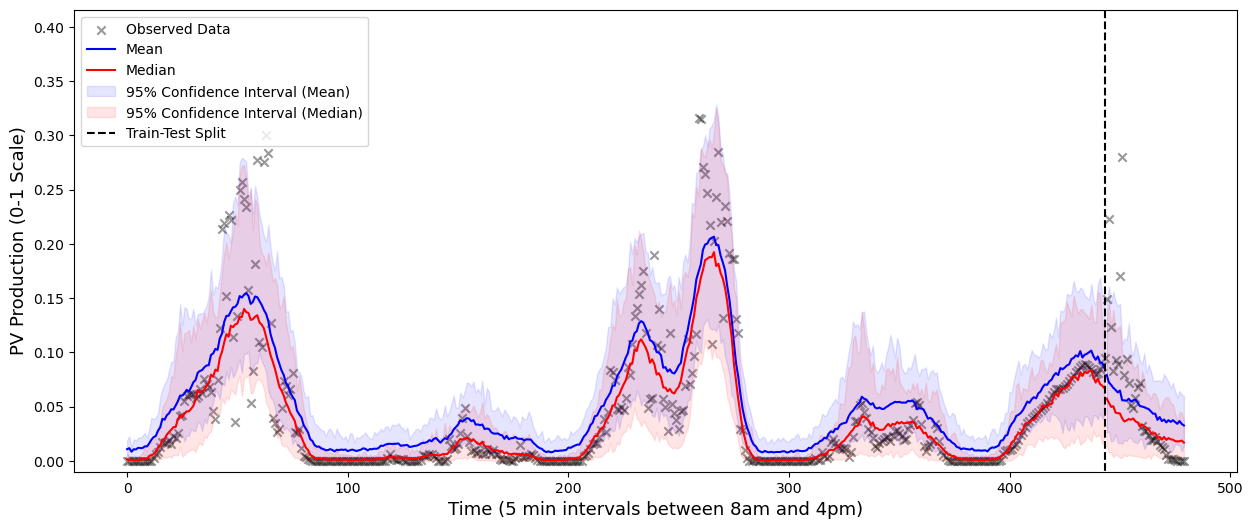

Iter 30/300 - Loss: -2.569
Iter 60/300 - Loss: -2.976
Iter 90/300 - Loss: -3.133
Iter 120/300 - Loss: -3.207
Iter 150/300 - Loss: -3.245
Iter 180/300 - Loss: -3.265
Iter 210/300 - Loss: -3.277
Iter 240/300 - Loss: -3.285
Iter 270/300 - Loss: -3.290
Iter 300/300 - Loss: -3.295


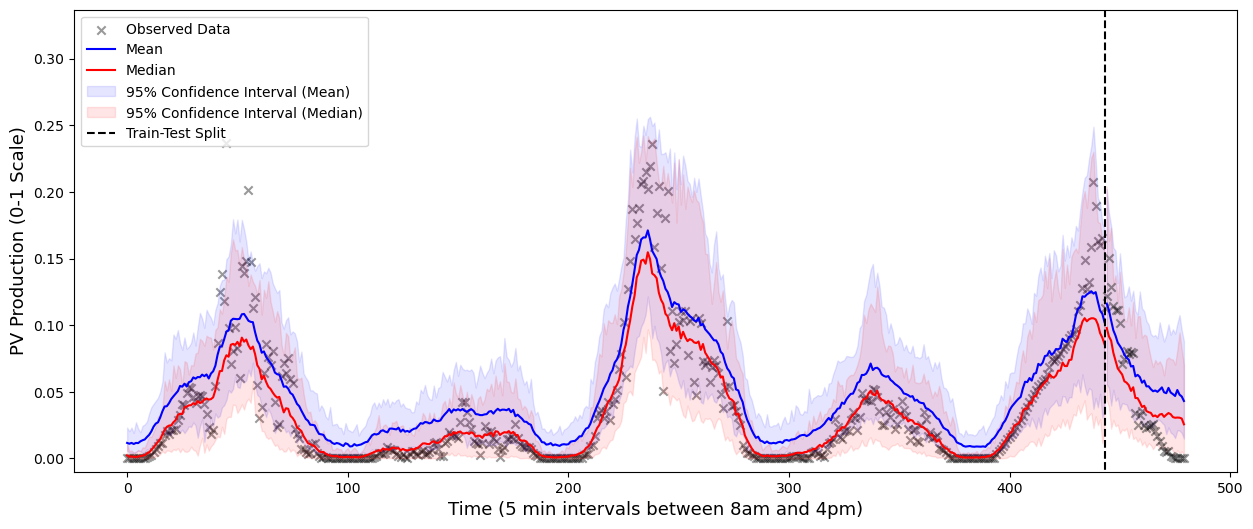

Iter 30/300 - Loss: -2.537
Iter 60/300 - Loss: -2.901
Iter 90/300 - Loss: -3.047
Iter 120/300 - Loss: -3.112
Iter 150/300 - Loss: -3.145
Iter 180/300 - Loss: -3.163
Iter 210/300 - Loss: -3.174
Iter 240/300 - Loss: -3.182
Iter 270/300 - Loss: -3.188
Iter 300/300 - Loss: -3.194


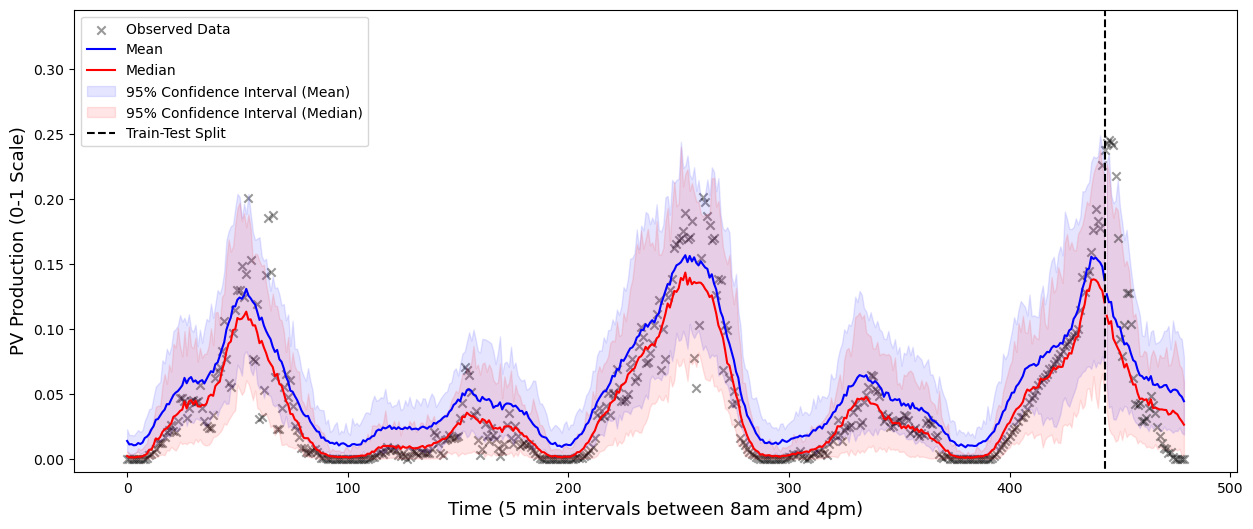

Iter 30/300 - Loss: -2.407
Iter 60/300 - Loss: -2.772
Iter 90/300 - Loss: -2.933
Iter 120/300 - Loss: -3.002
Iter 150/300 - Loss: -3.036
Iter 180/300 - Loss: -3.052
Iter 210/300 - Loss: -3.062
Iter 240/300 - Loss: -3.068
Iter 270/300 - Loss: -3.072
Iter 300/300 - Loss: -3.076


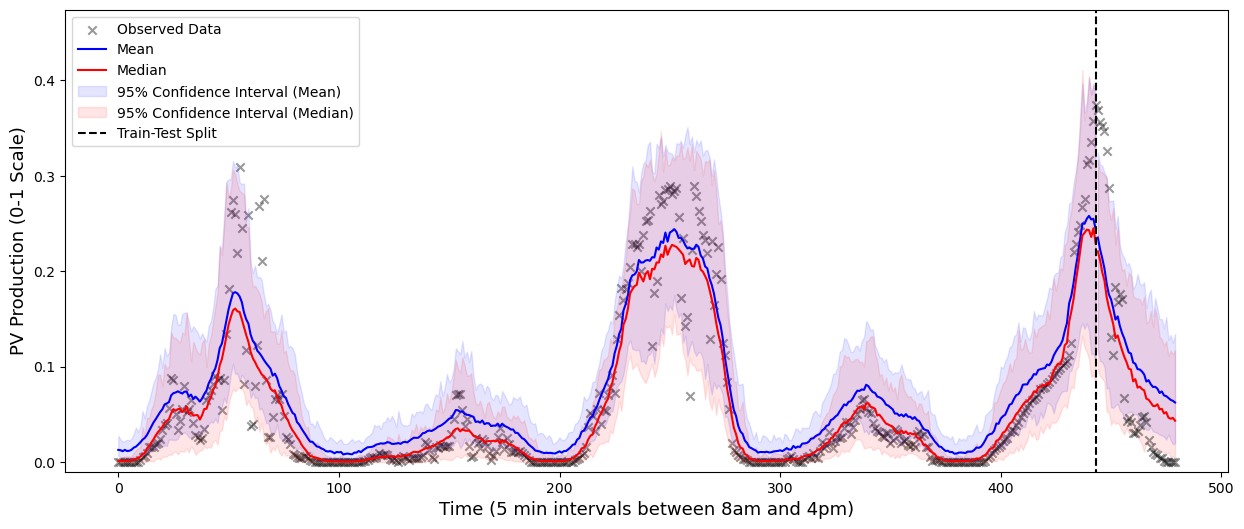

Iter 30/300 - Loss: -2.108
Iter 60/300 - Loss: -2.596
Iter 90/300 - Loss: -2.743
Iter 120/300 - Loss: -2.810
Iter 150/300 - Loss: -2.842
Iter 180/300 - Loss: -2.857
Iter 210/300 - Loss: -2.865
Iter 240/300 - Loss: -2.869
Iter 270/300 - Loss: -2.872
Iter 300/300 - Loss: -2.874


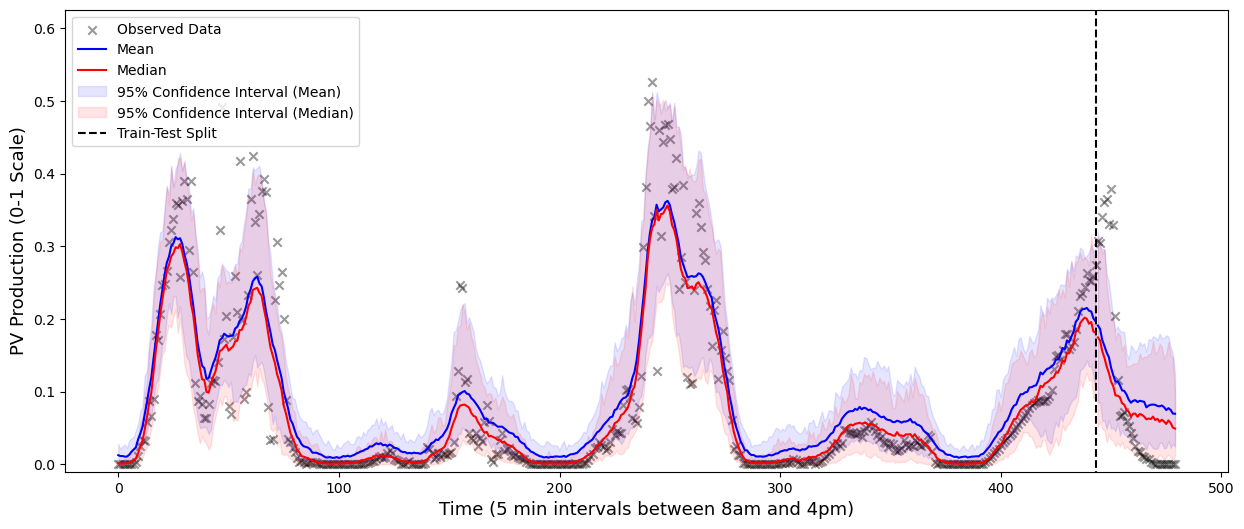

Iter 30/300 - Loss: -2.164
Iter 60/300 - Loss: -2.732
Iter 90/300 - Loss: -2.876
Iter 120/300 - Loss: -2.945
Iter 150/300 - Loss: -2.983
Iter 180/300 - Loss: -3.005
Iter 210/300 - Loss: -3.019
Iter 240/300 - Loss: -3.028
Iter 270/300 - Loss: -3.035
Iter 300/300 - Loss: -3.040


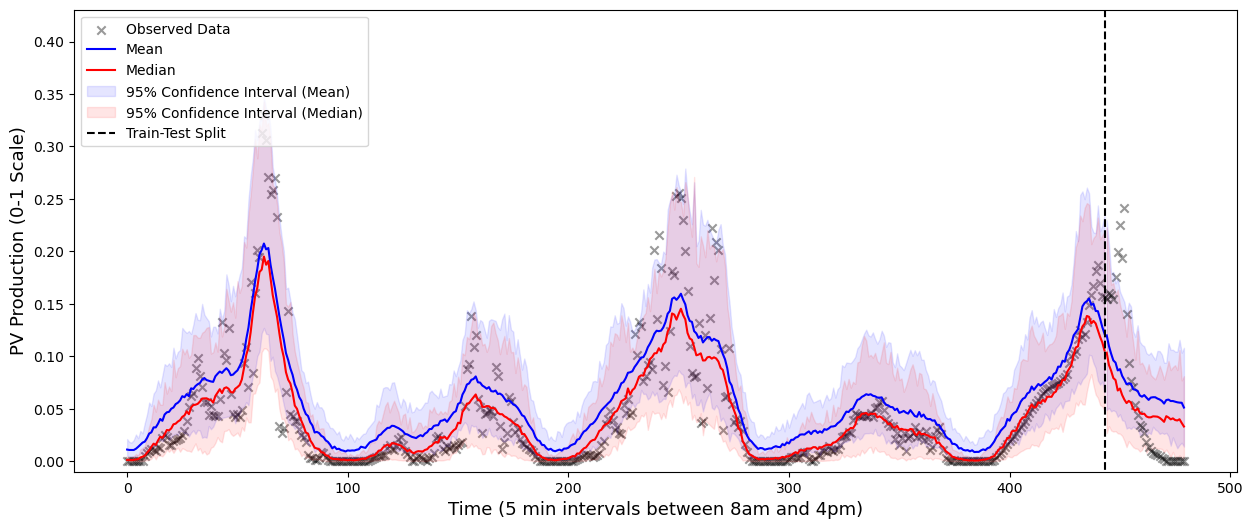

Iter 30/300 - Loss: -2.189
Iter 60/300 - Loss: -2.608
Iter 90/300 - Loss: -2.775
Iter 120/300 - Loss: -2.847
Iter 150/300 - Loss: -2.881
Iter 180/300 - Loss: -2.898
Iter 210/300 - Loss: -2.907
Iter 240/300 - Loss: -2.912
Iter 270/300 - Loss: -2.917
Iter 300/300 - Loss: -2.921


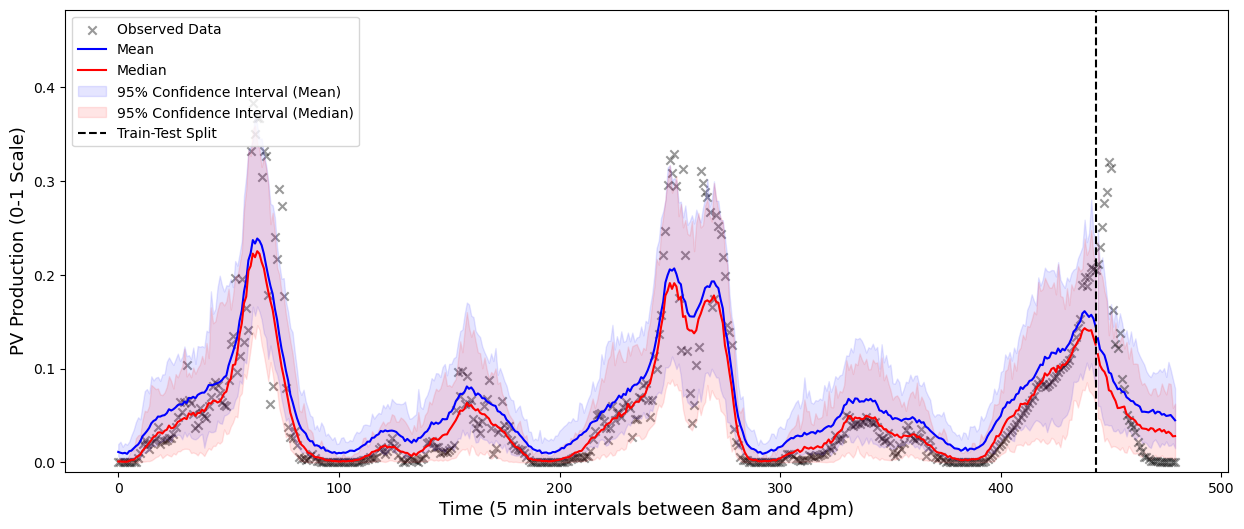

Iter 30/300 - Loss: -2.089
Iter 60/300 - Loss: -2.509
Iter 90/300 - Loss: -2.666
Iter 120/300 - Loss: -2.737
Iter 150/300 - Loss: -2.768
Iter 180/300 - Loss: -2.781
Iter 210/300 - Loss: -2.788
Iter 240/300 - Loss: -2.791
Iter 270/300 - Loss: -2.794
Iter 300/300 - Loss: -2.796


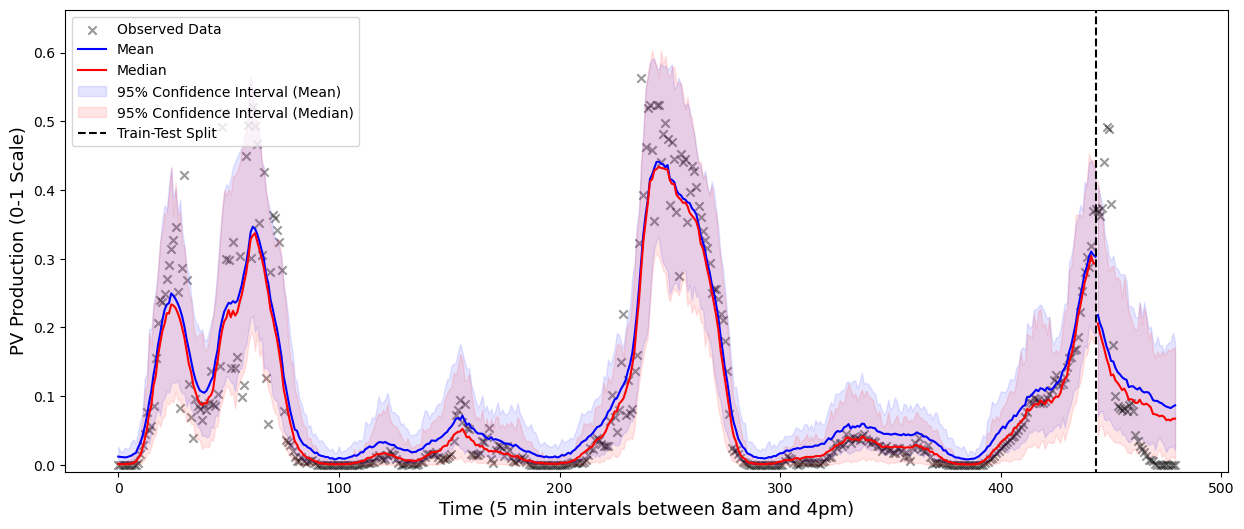

Iter 30/300 - Loss: -2.107
Iter 60/300 - Loss: -2.556
Iter 90/300 - Loss: -2.697
Iter 120/300 - Loss: -2.758
Iter 150/300 - Loss: -2.788
Iter 180/300 - Loss: -2.805
Iter 210/300 - Loss: -2.814
Iter 240/300 - Loss: -2.820
Iter 270/300 - Loss: -2.825
Iter 300/300 - Loss: -2.829


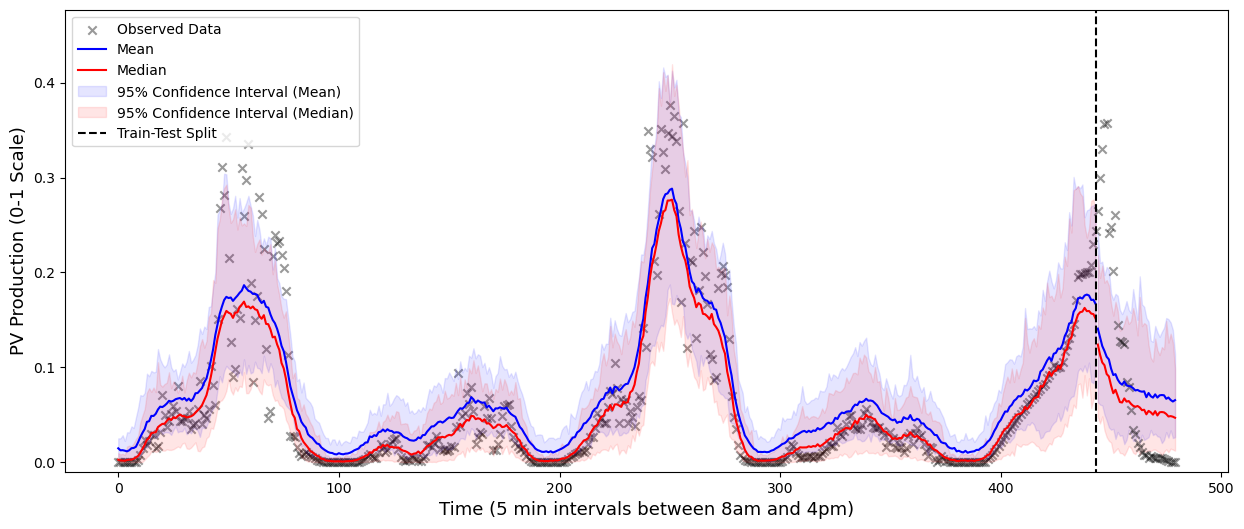

Iter 30/300 - Loss: -2.201
Iter 60/300 - Loss: -2.668
Iter 90/300 - Loss: -2.819
Iter 120/300 - Loss: -2.885
Iter 150/300 - Loss: -2.918
Iter 180/300 - Loss: -2.934
Iter 210/300 - Loss: -2.943
Iter 240/300 - Loss: -2.949
Iter 270/300 - Loss: -2.953
Iter 300/300 - Loss: -2.956


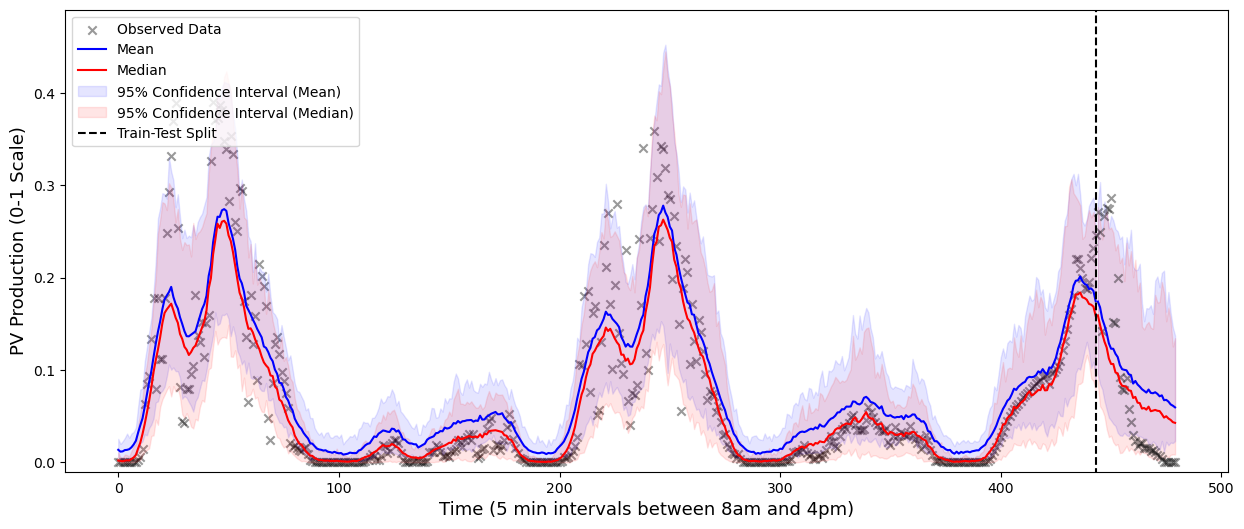

Iter 30/300 - Loss: -2.161
Iter 60/300 - Loss: -2.630
Iter 90/300 - Loss: -2.798
Iter 120/300 - Loss: -2.879
Iter 150/300 - Loss: -2.918
Iter 180/300 - Loss: -2.936
Iter 210/300 - Loss: -2.944
Iter 240/300 - Loss: -2.949
Iter 270/300 - Loss: -2.953
Iter 300/300 - Loss: -2.956


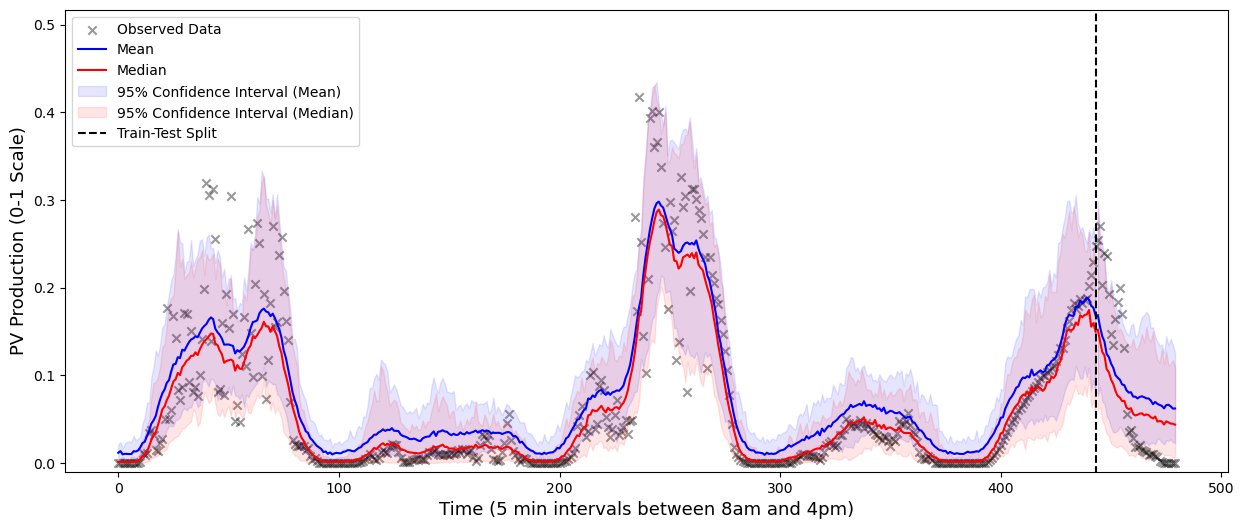

Iter 30/300 - Loss: -2.135
Iter 60/300 - Loss: -2.597
Iter 90/300 - Loss: -2.758
Iter 120/300 - Loss: -2.827
Iter 150/300 - Loss: -2.860
Iter 180/300 - Loss: -2.877
Iter 210/300 - Loss: -2.887
Iter 240/300 - Loss: -2.894
Iter 270/300 - Loss: -2.899
Iter 300/300 - Loss: -2.904


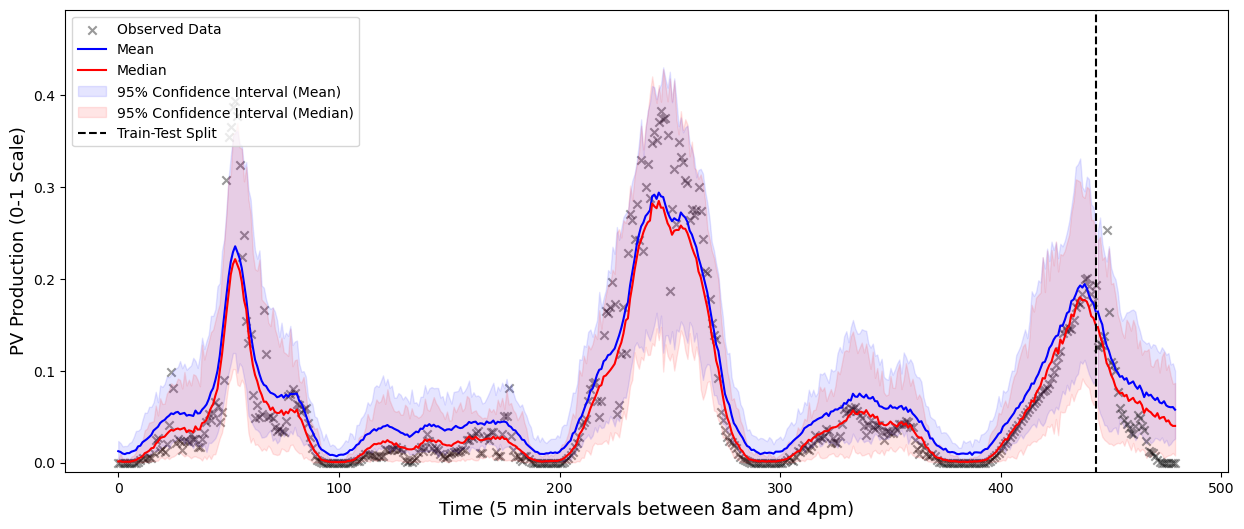

Iter 30/300 - Loss: -2.454
Iter 60/300 - Loss: -2.939
Iter 90/300 - Loss: -3.112
Iter 120/300 - Loss: -3.194
Iter 150/300 - Loss: -3.236
Iter 180/300 - Loss: -3.258
Iter 210/300 - Loss: -3.271
Iter 240/300 - Loss: -3.279
Iter 270/300 - Loss: -3.285
Iter 300/300 - Loss: -3.290


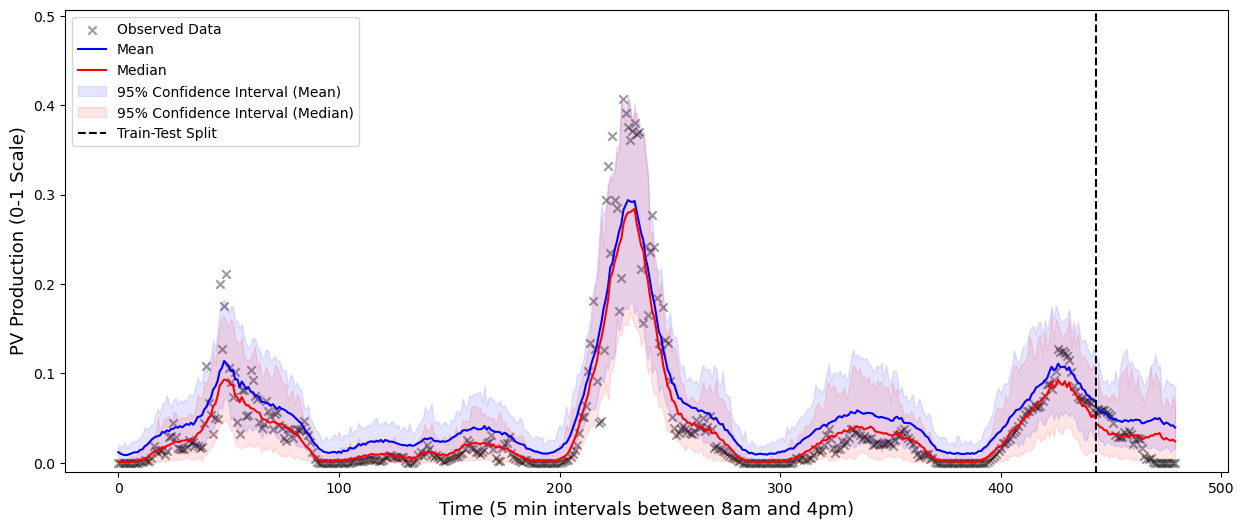

In [10]:
jitter = 1e-5

for idx in range(y_train.size(1)):
    
    config = {  'type': 'stochastic',
                'name': 'mean_field',
                'num_inducing_points': x_inducing.size(0),
                'mean_init_std': 1,
                }
    inputs_mean = { 'X': x_train, 'y': y_train[:, idx], 
                    'mean_module': gpytorch.means.ConstantMean(),
                    'covar_module': scaled_matern,
                    'likelihood': BetaLikelihood_MeanParametrization(scale=15,
                                                                        correcting_scale=1,
                                                                        lower_bound=0.10,
                                                                        upper_bound=0.80),
                    'config': config,
                    'jitter': jitter
                }

    model_beta = BetaGP(**inputs_mean)
    model_beta.fit(n_iter=300, lr=0.1, optim=torch.optim.Adam, device=torch.device('cpu'), verbose=True)    
    
    preds = model_beta.predict(x, device=torch.device('cpu'))
    plot_gp(model_beta, x_train, x_test, y_train[:,idx], y_test[:,idx], y_inducing=y_inducing[:,idx])


# Hyperparameter Optimization

In [9]:
from src.hyperparameter_tuning import HyperParameterOptimization

In [ ]:
config = {'type': 'stochastic',
            'name': 'mean_field',
            'num_inducing_points': x_train.size(0),
            'mean_init_std': 1,
            }

jitter = 1e-5

hyper_opt = HyperParameterOptimization( model='beta',
                                        x_train=x_train,
                                        y_train=y_train,
                                        x_test=x_test,
                                        y_test=y_test,
)
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: hyper_opt.objective(trial, config, jitter), n_trials=60)

In [12]:
from optuna.visualization import plot_optimization_history, plot_contour, plot_parallel_coordinate, plot_param_importances

In [13]:
plot_optimization_history(study)

In [14]:
plot_contour(study, params=[ 'lengthscale_rate', 'lengthscale_shape'])

In [15]:
plot_parallel_coordinate(study)

In [16]:
plot_param_importances(study)

In [17]:
best_params = study.best_params
best_params

{'lengthscale_shape': 2.0,
 'lengthscale_rate': 8.0,
 'signal_bound': 0.01,
 'likelihood_scale': 5.0,
 'likelihood_correcting_scale': 1.0,
 'lr': 0.050105336584070265}